In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import vbll

### SNGP Model

In [2]:
class DeepResNet(nn.Module):
    """Defines a multi-layer residual network."""
    def __init__(self, num_classes, in_dim=2, num_layers=3, num_hidden=128,
                 dropout_rate=0.1, **classifier_kwargs):
        super().__init__()
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.classifier_kwargs = classifier_kwargs

        self.input_layer = nn.Linear(in_dim, self.num_hidden)
        self.input_layer.weight.requires_grad = False
        self.input_layer.bias.requires_grad = False
        self.dense_layers = nn.ModuleList([self.make_dense_layer() for _ in range(num_layers)])
        self.dropout = nn.Dropout(self.dropout_rate)

        self.classifier = self.make_output_layer(num_classes)

    def forward(self, inputs):
        hidden = self.input_layer(inputs)

        for i in range(self.num_layers):
            resid = self.dense_layers[i](hidden)
            resid = self.dropout(resid)
            hidden += resid

        return self.classifier(hidden)

    def make_dense_layer(self):
        """Uses the Linear layer as the hidden layer."""
        return nn.Linear(self.num_hidden, self.num_hidden)

    def make_output_layer(self, num_classes):
        """Uses the Linear layer as the output layer."""
        return nn.Linear(self.num_hidden, num_classes, **self.classifier_kwargs)

class SpectralNormalization(nn.Module):
    def __init__(self, module, norm_multiplier=0.9, n_power_iterations=1, name='weight', dim=0, eps=1e-12):
        super().__init__()
        self.module = module
        self.name = name
        self.dim = dim
        self.norm_multiplier = norm_multiplier
        self.n_power_iterations = n_power_iterations
        self.eps = eps

        weight = getattr(self.module, self.name)

        with torch.no_grad():
            self.u = F.normalize(weight.data.new(weight.size(0)).normal_(0, 1), dim=0, eps=self.eps)

        self.reset_parameters()

    def reset_parameters_old(self):
        setattr(self.module, self.name, self.norm_multiplier * getattr(self.module, self.name))

    def reset_parameters(self):
        weight = getattr(self.module, self.name)
        new_weight = self.norm_multiplier * weight
        setattr(self.module, self.name, nn.Parameter(new_weight))

    def _power_method(self, weight):
        for _ in range(self.n_power_iterations):
            v = F.normalize(torch.matmul(weight.t(), self.u), dim=0, eps=self.eps)
            self.u = F.normalize(torch.matmul(weight, v), dim=0, eps=self.eps)

        sigma = torch.dot(self.u, torch.matmul(weight, v))
        return sigma, self.u, v

    def forward(self, *args):
        weight = getattr(self.module, self.name)
        sigma, _, _ = self._power_method(weight)
        weight = weight / sigma * self.norm_multiplier
        return self.module(*args)

class RandomFeatureGaussianProcess(nn.Module):
    def __init__(self, num_classes, num_inducing=1024, gp_cov_momentum=-1, **kwargs):
        super().__init__()
        self.num_classes = num_classes
        self.num_inducing = num_inducing
        self.gp_cov_momentum = gp_cov_momentum
        
        self.random_features = nn.Linear(kwargs.get('input_dim', 128), num_inducing)
        nn.init.normal_(self.random_features.weight, std=1.0)
        self.random_features.weight.requires_grad = False
        self.random_features.bias.requires_grad = False

        self.gp_layer = nn.Linear(num_inducing, num_classes)
        
        self.register_buffer('covmat', torch.eye(num_classes))

    def reset_covariance_matrix(self):
        self.covmat = torch.eye(self.num_classes, device=self.covmat.device)

    def forward(self, x):
        features = torch.cos(self.random_features(x))
        logits = self.gp_layer(features)
        
        if self.training:
            cov = features.t() @ features
            if self.gp_cov_momentum <= 0:
                self.covmat = cov
            else:
                self.covmat = (self.gp_cov_momentum * self.covmat + 
                               (1 - self.gp_cov_momentum) * cov)
        
        return logits, self.covmat

class DeepResNetSNGP(DeepResNet):
    def __init__(self, spec_norm_bound=0.9, **kwargs):
        self.spec_norm_bound = spec_norm_bound
        super().__init__(**kwargs)

    def make_dense_layer(self):
        """Applies spectral normalization to the hidden layer."""
        dense_layer = super().make_dense_layer()
        return SpectralNormalization(dense_layer, norm_multiplier=self.spec_norm_bound)

    def make_output_layer(self, num_classes):
        """Uses Gaussian process as the output layer."""
        return RandomFeatureGaussianProcess(
            num_classes,
            input_dim=self.num_hidden,
            gp_cov_momentum=-1,
            **self.classifier_kwargs)

    def forward(self, inputs, training=False, return_covmat=False):
        hidden = self.input_layer(inputs)

        for i in range(self.num_layers):
            resid = self.dense_layers[i](hidden)
            resid = self.dropout(resid)
            hidden = hidden + resid

        logits, covmat = self.classifier(hidden)

        if not training and return_covmat:
            return logits, covmat

        return logits

### Data

In [3]:
def labels_to_markers(y):
    return list(np.where(y == 0, 'o', 'x'))
    markers = np.array(['o'] * len(y))
    markers[y == 1] = "x"
    return markers

In [4]:
def generate_data(n_samples=1000):
    X = np.random.randn(n_samples, 2)
    y = (X[:, 0] + X[:, 1] > 0).astype(int)
    return X, y

In [5]:
def generate_moon_data(num_samples=1000, noise_std=0.1, theta=np.pi/4):

    blob1 = np.random.randn(num_samples // 2, 2) + np.array([[-2, 0]])
    blob2 = np.random.randn(num_samples // 2, 2) + np.array([[2, 0]])

    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])
    blob1 = np.dot(blob1, rotation_matrix)
    blob2 = np.dot(blob2, rotation_matrix)

    data = np.concatenate([blob1, blob2], axis=0)
    data += np.random.randn(*data.shape) * noise_std
    labels = np.array([0] * (num_samples // 2) + [1] * (num_samples // 2))
    return data, labels

def generate_two_moons_data(num_samples=1000, noise_std=0.1, shift=0.5):
    theta = np.linspace(0, np.pi, num_samples // 2)

    moon1_x = np.cos(theta) + np.random.normal(0, noise_std, num_samples // 2)
    moon1_y = np.sin(theta) + np.random.normal(0, noise_std, num_samples // 2)

    moon2_x = np.cos(theta + np.pi) + np.random.normal(0, noise_std, num_samples // 2) + shift
    moon2_y = np.sin(theta + np.pi) - np.random.normal(0, noise_std, num_samples // 2) + shift

    X = np.vstack([np.hstack([moon1_x, moon2_x]), np.hstack([moon1_y, moon2_y])]).T
    y = np.hstack([np.zeros(num_samples // 2), np.ones(num_samples // 2)])

    return X, y

In [6]:
def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
    return np.random.multivariate_normal(
        means, cov=np.diag(vars), size=sample_size)

In [7]:
def load_banana_data(banana_data_path, banana_class_path):
    X_banana = np.loadtxt(banana_data_path, delimiter=",")
    y_banana = np.loadtxt(banana_class_path, delimiter=",")
    N_samples_banana = len(X_banana)
    N_test_samples_banana = int(0.1 * N_samples_banana)
    permutation = np.random.permutation(N_samples_banana)
    X_banana = X_banana[permutation]
    y_banana = y_banana[permutation]

    X_test_banana = X_banana[:N_test_samples_banana]
    y_test_banana = y_banana[:N_test_samples_banana]
    X_train_banana = X_banana[N_test_samples_banana:]
    y_train_banana = y_banana[N_test_samples_banana:]
    return X_train_banana, y_train_banana, X_test_banana, y_test_banana

In [8]:
# SEED FOR DATA
torch.manual_seed(42)
np.random.seed(42)

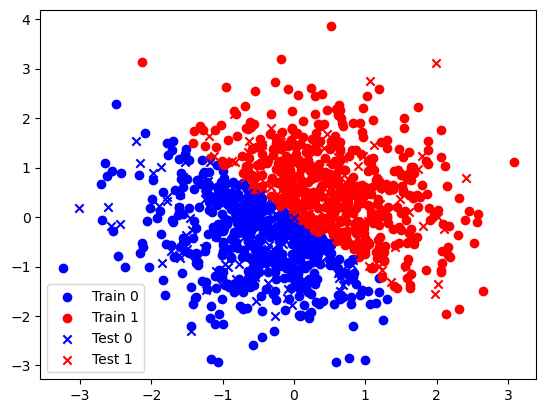

In [9]:
X_train_linear, y_train_linear = generate_data(1000)
X_test_linear, y_test_linear = generate_data(200)

train_dataset_linear = TensorDataset(torch.FloatTensor(X_train_linear), torch.LongTensor(y_train_linear))
test_dataset_linear = TensorDataset(torch.FloatTensor(X_test_linear), torch.LongTensor(y_test_linear))

train_loader_linear = DataLoader(train_dataset_linear, batch_size=32, shuffle=True)
test_loader_linear = DataLoader(test_dataset_linear, batch_size=32, shuffle=False)

# ALL
# plt.scatter(X_train_linear[:,0], X_train_linear[:,1], c=y_train_linear, marker="o", label="train")
# plt.scatter(X_test_linear[:,0], X_test_linear[:,1], c=y_test_linear, marker"+, label="test")

# GROUP
plt.scatter(X_train_linear[y_train_linear == 0][:, 0], X_train_linear[y_train_linear == 0][:, 1], color='blue', marker="o", label='Train 0')
plt.scatter(X_train_linear[y_train_linear == 1][:, 0], X_train_linear[y_train_linear == 1][:, 1], color='red', marker="o", label='Train 1')
plt.scatter(X_test_linear[y_test_linear == 0][:, 0], X_test_linear[y_test_linear == 0][:, 1], color='blue', marker="x", label='Test 0 ')
plt.scatter(X_test_linear[y_test_linear == 1][:, 0], X_test_linear[y_test_linear == 1][:, 1], color='red', marker="x", label='Test 1')

# INDIVIDUAL
# for i, (x, y, m) in enumerate(zip(X_train_linear[:,0], X_train_linear[:,1], labels_to_markers(y_train_linear))):
#     plt.scatter(x, y, marker=m, c="g")
# for i, (x, y, m) in enumerate(zip(X_test_linear[:,0], X_test_linear[:,1], labels_to_markers(y_test_linear))):
#     plt.scatter(x, y, marker=m, c="b")

plt.legend()

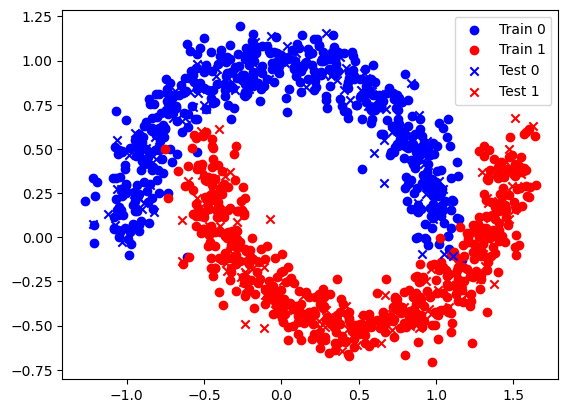

In [10]:
X_train_moons, y_train_moons = generate_two_moons_data(1000)
X_test_moons, y_test_moons = generate_two_moons_data(200)

train_dataset_moons = TensorDataset(torch.FloatTensor(X_train_moons), torch.LongTensor(y_train_moons))
test_dataset_moons = TensorDataset(torch.FloatTensor(X_test_moons), torch.LongTensor(y_test_moons))

train_loader_moons = DataLoader(train_dataset_moons, batch_size=32, shuffle=True)
test_loader_moons = DataLoader(test_dataset_moons, batch_size=32, shuffle=False)

# ALL
# plt.scatter(X_train_moons[:,0], X_train_moons[:,1], c=y_train_moons, marker="o", label="train")
# plt.scatter(X_test_moons[:,0], X_test_moons[:,1], c=y_test_moons, marker="x", label="test")

# GROUP
plt.scatter(X_train_moons[y_train_moons == 0][:, 0], X_train_moons[y_train_moons == 0][:, 1], color='blue', marker="o", label='Train 0')
plt.scatter(X_train_moons[y_train_moons == 1][:, 0], X_train_moons[y_train_moons == 1][:, 1], color='red', marker="o", label='Train 1')
plt.scatter(X_test_moons[y_test_moons == 0][:, 0], X_test_moons[y_test_moons == 0][:, 1], color='blue', marker="x", label='Test 0 ')
plt.scatter(X_test_moons[y_test_moons == 1][:, 0], X_test_moons[y_test_moons == 1][:, 1], color='red', marker="x", label='Test 1')

# INDIVIDUAL
# for i, (x, y, m) in enumerate(zip(X_train_moons[:,0], X_train_moons[:,1], labels_to_markers(y_train_moons))):
#     plt.scatter(x, y, marker=m, c="g")
# for i, (x, y, m) in enumerate(zip(X_test_moons[:,0], X_test_moons[:,1], labels_to_markers(y_test_moons))):
#     plt.scatter(x, y, marker=m, c="b")
plt.legend()

In [11]:
X_train_banana, y_train_banana, X_test_banana, y_test_banana = load_banana_data("datapoints.csv", "classes.csv")

train_dataset_banana = TensorDataset(torch.FloatTensor(X_train_banana), torch.LongTensor(y_train_banana))
test_dataset_banana = TensorDataset(torch.FloatTensor(X_test_banana), torch.LongTensor(y_test_banana))

train_loader_banana = DataLoader(train_dataset_banana, batch_size=32, shuffle=True)
test_loader_banana = DataLoader(test_dataset_banana, batch_size=32, shuffle=False)

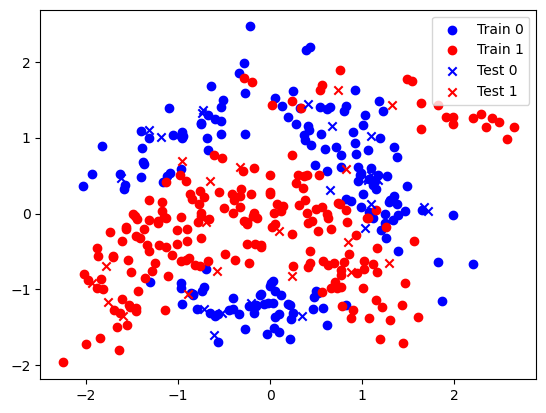

In [12]:
# ALL
# plt.scatter(X_train_linear[:,0], X_train_linear[:,1], c=y_train_linear, marker="o", label="train")
# plt.scatter(X_test_linear[:,0], X_test_linear[:,1], c=y_test_linear, marker"+, label="test")

# GROUP
plt.scatter(X_train_banana[y_train_banana == 0][:, 0], X_train_banana[y_train_banana == 0][:, 1], color='blue', marker="o", label='Train 0')
plt.scatter(X_train_banana[y_train_banana == 1][:, 0], X_train_banana[y_train_banana == 1][:, 1], color='red', marker="o", label='Train 1')
plt.scatter(X_test_banana[y_test_banana == 0][:, 0], X_test_banana[y_test_banana == 0][:, 1], color='blue', marker="x", label='Test 0 ')
plt.scatter(X_test_banana[y_test_banana == 1][:, 0], X_test_banana[y_test_banana == 1][:, 1], color='red', marker="x", label='Test 1')

# INDIVIDUAL
# for i, (x, y, m) in enumerate(zip(X_train_linear[:,0], X_train_linear[:,1], labels_to_markers(y_train_linear))):
#     plt.scatter(x, y, marker=m, c="g")
# for i, (x, y, m) in enumerate(zip(X_test_linear[:,0], X_test_linear[:,1], labels_to_markers(y_test_linear))):
#     plt.scatter(x, y, marker=m, c="b")

plt.legend()

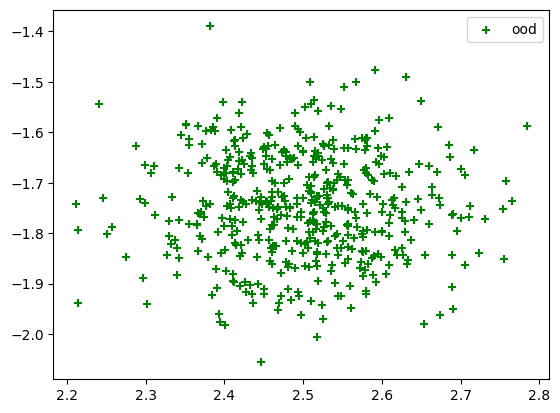

In [13]:
X_ood = make_ood_data()
plt.scatter(X_ood[:,0], X_ood[:,1], color="green", marker="+", label="ood")
plt.legend()

In [14]:
data_dict = {
    "linear": (train_loader_linear, test_loader_linear, X_train_linear, y_train_linear, X_test_linear, y_test_linear),
    "moons": (train_loader_moons, test_loader_moons, X_train_moons, y_train_moons, X_test_moons, y_test_moons),
    "banana": (train_loader_banana, test_loader_banana, X_train_banana, y_train_banana, X_test_banana, y_test_banana),
}

### training

In [15]:
def init_training_sngp(num_classes=2, num_layers=3, num_hidden=64, dropout_rate=0.1, lr=0.001):
    model = DeepResNetSNGP(num_classes=num_classes, num_layers=num_layers, num_hidden=num_hidden, dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=lr) # optim.SGD(model.parameters(), lr=lr)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    return model, criterion, optimizer

In [16]:
def proceed_training_sngp(model, train_loader, test_loader, optimizer, criterion, num_epochs):
    num_epochs = 10
    losses = []
    accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        losses.append(running_loss)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
            f'Test Accuracy: {100 * correct / total:.2f}%')
        accuracies.append(correct / total)
    return losses, accuracies

In [17]:
def proceed_testing_sngp(model, X):
    model.eval()
    X_test_tensor = torch.FloatTensor(X)
    with torch.no_grad():
        logits, covmat = model(X_test_tensor, training=False, return_covmat=True)
        probas = torch.softmax(logits, dim=1)
        predictions = torch.argmax(probas, dim=1)
        uncertainties = probas[:,0] * probas[:,1] # TODO: @Tomek how to use covmat
    return probas, predictions, uncertainties

Luźne podejście do uncertainties

logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(logits, covmat, mean_field_factor=lambda_param)


tf.nn.softmax(logits_adjusted, axis=-1)[:, 0]

In [18]:
# SEED FOR MODELS
torch.manual_seed(8)
np.random.seed(8)

In [19]:
data_str = "moons"
train_loader, test_loader, X_train, y_train, X_test, y_test = data_dict[data_str]

In [20]:
model_sngp, criterion, optimizer = init_training_sngp()
losses, accuracies = proceed_training_sngp(model_sngp, train_loader, test_loader, optimizer, criterion, num_epochs=10)
probas_sngp, predictions_sngp, uncertainties_sngp = proceed_testing_sngp(model_sngp, X_test)

/home/pyla/miniconda3/envs/bfn2/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch [1/10], Loss: 0.6342, Test Accuracy: 82.00%
Epoch [2/10], Loss: 0.6358, Test Accuracy: 93.00%
Epoch [3/10], Loss: 0.4652, Test Accuracy: 94.00%
Epoch [4/10], Loss: 0.5293, Test Accuracy: 94.50%
Epoch [5/10], Loss: 0.3991, Test Accuracy: 95.50%
Epoch [6/10], Loss: 0.6912, Test Accuracy: 95.50%
Epoch [7/10], Loss: 0.4309, Test Accuracy: 96.50%
Epoch [8/10], Loss: 0.4547, Test Accuracy: 96.00%
Epoch [9/10], Loss: 0.5422, Test Accuracy: 96.00%
Epoch [10/10], Loss: 0.2510, Test Accuracy: 96.50%


Text(0.5, 1.0, 'test acc')

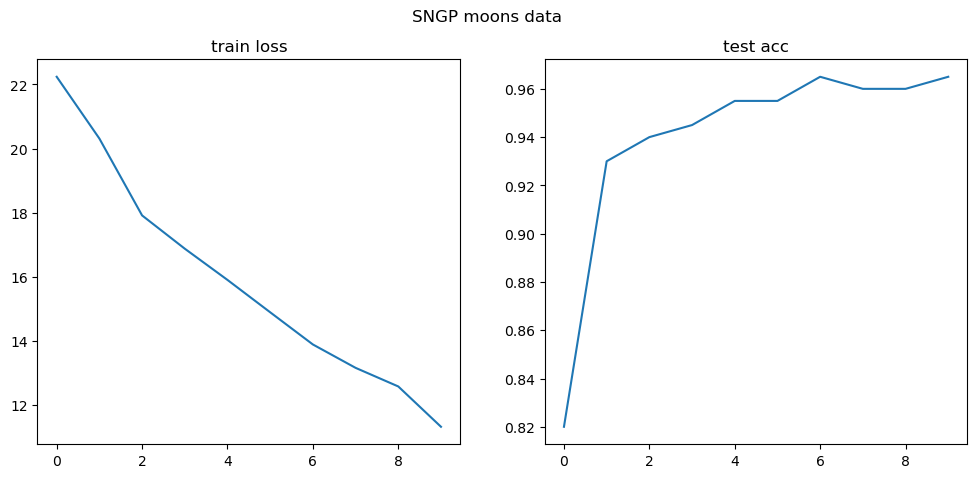

In [21]:
plt.figure(figsize=(12, 5))
plt.suptitle(f"SNGP {data_str} data")
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("train loss")
plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title("test acc")

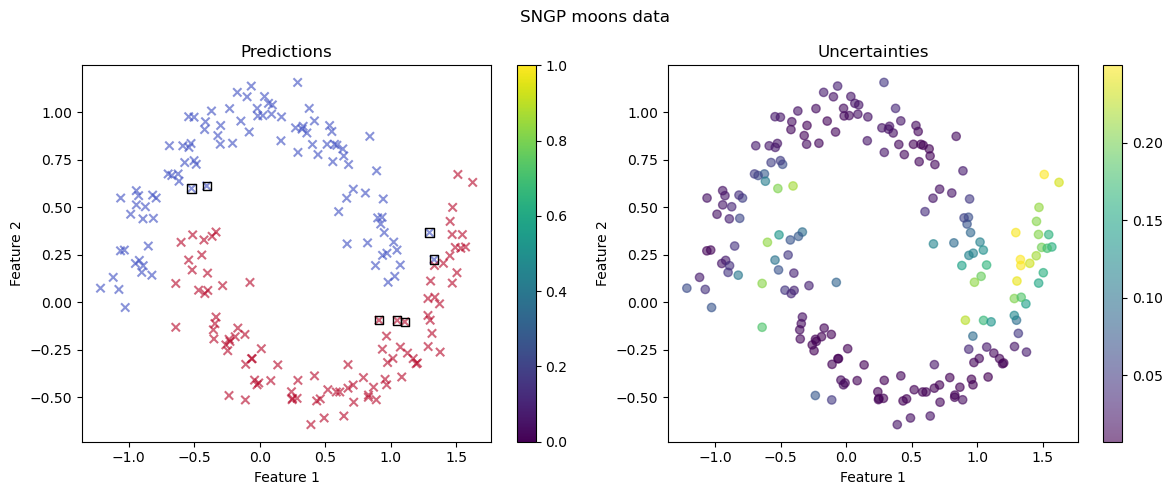

In [22]:
plt.figure(figsize=(12, 5))
plt.suptitle(f"SNGP {data_str} data")
plt.subplot(1, 2, 1)
# ALL
# scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=predictions, cmap='coolwarm', alpha=0.6)
# plt.colorbar(scatter)

# GROUP
plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c=predictions_sngp[y_test == 0], cmap='coolwarm', marker="x", alpha=0.6, label='Test 0')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c=predictions_sngp[y_test == 1], cmap='coolwarm', marker="x", alpha=0.6, label='Test 1')
misclassified = predictions_sngp.numpy() != y_test
plt.scatter(X_test[misclassified][:, 0], X_test[misclassified][:, 1], edgecolors="black", facecolors='none', marker="s", alpha=1.0, label="misclassified")
plt.colorbar()
plt.title('Predictions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
# ALL
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=uncertainties_sngp, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)

plt.title('Predictions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.title('Uncertainties')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

### VBLL

In [23]:
class DeepResNetVBLL(nn.Module):
    """Defines a multi-layer residual network."""
    def __init__(self, vbll_cfg, num_classes, in_dim=2, num_layers=3, num_hidden=128,
                 dropout_rate=0.1, **classifier_kwargs):
        super().__init__()
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.classifier_kwargs = classifier_kwargs

        self.input_layer = nn.Linear(in_dim, self.num_hidden)
        self.input_layer.weight.requires_grad = False
        self.input_layer.bias.requires_grad = False
        self.dense_layers = nn.ModuleList([self.make_dense_layer() for _ in range(num_layers)])
        self.dropout = nn.Dropout(self.dropout_rate)

        self.classifier = self.make_disc_vbll_layer(num_hidden, num_classes, vbll_cfg) if vbll_cfg.TYPE == "disc" else self.make_gen_vbll_layer(num_hidden, num_classes, vbll_cfg)

    def forward(self, inputs):
        hidden = self.input_layer(inputs)

        for i in range(self.num_layers):
            resid = self.dense_layers[i](hidden)
            resid = self.dropout(resid)
            hidden = hidden + resid

        return self.classifier(hidden) # out = [out.train_loss_fn(y), out.train_loss_fn_empirical(y, train_cfg.N_SAMPLES), out.predictive.probs]

    def make_dense_layer(self):
        """Uses the Linear layer as the hidden layer."""
        return nn.Linear(self.num_hidden, self.num_hidden)

    def make_disc_vbll_layer(self, num_hidden, num_classes, cfg):
        """Replace VBLL classification head."""
        return vbll.DiscClassification(num_hidden, 
                                        num_classes, 
                                        cfg.REG_WEIGHT, 
                                        softmax_bound=cfg.SOFTMAX_BOUND, 
                                        return_empirical=cfg.RETURN_EMPIRICAL, 
                                        softmax_bound_empirical=cfg.SOFTMAX_BOUND_EMPIRICAL, 
                                        parameterization = cfg.PARAM, 
                                        return_ood=cfg.RETURN_OOD, 
                                        prior_scale=cfg.PRIOR_SCALE)

    def make_gen_vbll_layer(self, num_hidden, num_classes, cfg):
        """Replace VBLL classification head."""
        return vbll.GenClassification(num_hidden, 
                                        num_classes, 
                                        cfg.REG_WEIGHT, 
                                        softmax_bound=cfg.SOFTMAX_BOUND, 
                                        return_empirical=cfg.RETURN_EMPIRICAL, 
                                        softmax_bound_empirical=cfg.SOFTMAX_BOUND_EMPIRICAL, 
                                        parameterization = cfg.PARAM, 
                                        return_ood=cfg.RETURN_OOD, 
                                        prior_scale=cfg.PRIOR_SCALE)
    
    def logit_predictive(self, x):
        hidden = self.input_layer(x)

        for i in range(self.num_layers):
            resid = self.dense_layers[i](hidden)
            resid = self.dropout(resid)
            hidden = hidden + resid
        
        return self.classifier.logit_predictive(hidden)
    
    def logit_predictive_likedisc(self, x, n_samples):
        hidden = self.input_layer(x)

        for i in range(self.num_layers):
            resid = self.dense_layers[i](hidden)
            resid = self.dropout(resid)
            hidden = hidden + resid
        
        return self.classifier.logit_predictive_likedisc(hidden, n_samples)

    def predictive(self, x, n_samples = 10):
        hidden = self.input_layer(x)

        for i in range(self.num_layers):
            resid = self.dense_layers[i](hidden)
            resid = self.dropout(resid)
            hidden = hidden + resid

        return self.classifier.predictive(hidden, n_samples)


In [24]:
def init_training_vbll(vbll_cfg, num_classes=2, num_layers=3, num_hidden=64, dropout_rate=0.1, lr=0.001):
    model = DeepResNetVBLL(vbll_cfg, num_classes=num_classes, num_layers=num_layers, num_hidden=num_hidden, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return model, optimizer

In [25]:
def proceed_training_vbll(model, train_loader, optimizer, num_epochs):
    losses = []
    accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = []
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            out = model(batch_X)
            loss = out.train_loss_fn(batch_y)
            running_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        losses.append(np.mean(running_loss))
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                out = model(batch_X)
                probs = out.predictive.probs
                predicted = torch.argmax(probs, 1) 
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {losses[-1]:.4f}, '
            f'Test Accuracy: {100 * correct / total:.2f}%')
        accuracies.append(correct / total)
    return losses, accuracies

In [26]:
def proceed_testing_vbll(model, X):
    model.eval()
    X_test_tensor = torch.FloatTensor(X)
    with torch.no_grad():
        out = model(X_test_tensor)
        probs = out.predictive.probs
        predicted = torch.argmax(probs, 1) 
        p_1minusp = probs[:,0] * probs[:,1]
    return probs, predicted, p_1minusp

### VBLL uncertainity

In [38]:
def proceed_logits_stddev_vbll(model, vbll_type, X, Y,  n_samples):
    if vbll_type == "disc":
        points = torch.from_numpy(np.column_stack((X.flatten(), Y.flatten()))).to(model.input_layer.weight.dtype)
        with torch.no_grad():
            softmax_samples = F.softmax(model.logit_predictive(points).rsample(sample_shape=torch.Size([n_samples])), dim=-1)
        first_class_predictions = softmax_samples[:, :, 0]
        standard_deviation = first_class_predictions.std(dim=0)
        return standard_deviation
    elif vbll_type == "gen":
        points = torch.from_numpy(np.column_stack((X.flatten(), Y.flatten()))).to(model.input_layer.weight.dtype)
        with torch.no_grad():
            out = model.logit_predictive_likedisc(points, n_samples = 10)
            softmax_samples = torch.clip(F.softmax(out, dim=-1), min=0., max=1.)
        first_class_predictions = softmax_samples[:, :, 0]
        standard_deviation = first_class_predictions.std(dim=0)
        return standard_deviation

def proceed_predictions_stddev_vbll(model, X, Y, n_repeats):
    # (1-p)*p i srdenia po p z sieci total variance law
    points = torch.from_numpy(np.column_stack((X.flatten(), Y.flatten()))).to(model.input_layer.weight.dtype)
    predictions = torch.empty((n_repeats, len(points)))
    for i in range(n_repeats):
        with torch.no_grad():
            out = model(points)
        probs = out.predictive.probs
        predictions[i] = probs[:, 0]
    return predictions.std(dim=0)
    
def proceed_prediction_grid_vbll(model, X, Y):
    points = torch.from_numpy(np.column_stack((X.flatten(), Y.flatten()))).to(model.input_layer.weight.dtype)
    with torch.no_grad():
        out = model(points)
    probs = out.predictive.probs
    return probs

In [27]:
class vbll_disc_cfg:
    TYPE = "disc"
    REG_WEIGHT = 1./len(X_train)
    PARAM = 'diagonal'
    SOFTMAX_BOUND = "jensen"
    RETURN_EMPIRICAL = True
    SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
    RETURN_OOD = True
    PRIOR_SCALE = 1.

In [166]:
model_vbll, optimizer_vbll = init_training_vbll(vbll_disc_cfg, lr=0.001)
losses_vbll, accuracies_vbll = proceed_training_vbll(model_vbll, train_loader, optimizer_vbll, num_epochs=50)
probs_vbll, predictions_vbll, simple_uncertainties_vbll = proceed_testing_vbll(model_vbll, X_test)

Epoch [1/50], Train Loss: 1.8465, Test Accuracy: 83.50%
Epoch [2/50], Train Loss: 1.1815, Test Accuracy: 85.00%
Epoch [3/50], Train Loss: 1.0055, Test Accuracy: 85.50%
Epoch [4/50], Train Loss: 0.9158, Test Accuracy: 86.50%
Epoch [5/50], Train Loss: 0.8967, Test Accuracy: 84.00%
Epoch [6/50], Train Loss: 0.8466, Test Accuracy: 82.00%
Epoch [7/50], Train Loss: 0.8765, Test Accuracy: 85.00%
Epoch [8/50], Train Loss: 0.8271, Test Accuracy: 84.50%
Epoch [9/50], Train Loss: 0.8350, Test Accuracy: 82.00%
Epoch [10/50], Train Loss: 0.8284, Test Accuracy: 85.00%
Epoch [11/50], Train Loss: 0.7960, Test Accuracy: 86.00%
Epoch [12/50], Train Loss: 0.7770, Test Accuracy: 82.50%
Epoch [13/50], Train Loss: 0.7763, Test Accuracy: 83.50%
Epoch [14/50], Train Loss: 0.7633, Test Accuracy: 82.00%
Epoch [15/50], Train Loss: 0.7586, Test Accuracy: 85.50%
Epoch [16/50], Train Loss: 0.7476, Test Accuracy: 85.50%
Epoch [17/50], Train Loss: 0.7479, Test Accuracy: 85.00%
Epoch [18/50], Train Loss: 0.7632, Test 

Text(0.5, 1.0, 'test acc')

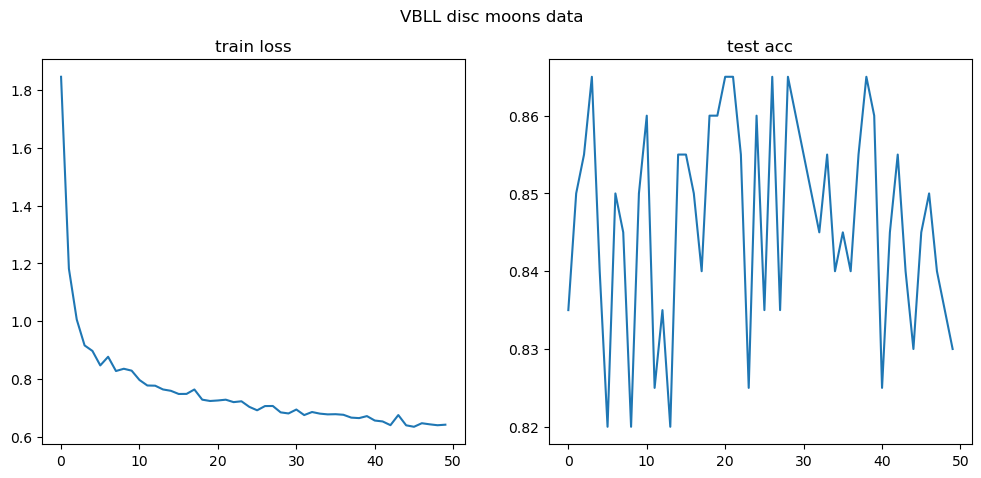

In [167]:
plt.figure(figsize=(12, 5))
plt.suptitle(f"VBLL {vbll_disc_cfg.TYPE} {data_str} data")
plt.subplot(1, 2, 1)
plt.plot(losses_vbll)
plt.title("train loss")
plt.subplot(1, 2, 2)
plt.plot(accuracies_vbll)
plt.title("test acc")

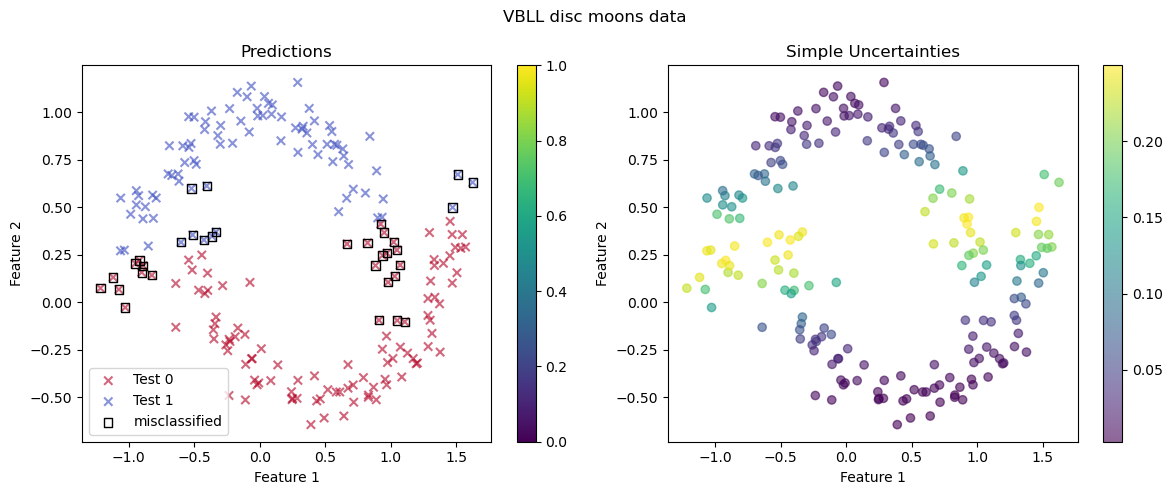

In [168]:
plt.figure(figsize=(12, 5))
plt.suptitle(f"VBLL {vbll_disc_cfg.TYPE} {data_str} data")
plt.subplot(1, 2, 1)
# ALL
# scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=predictions, cmap='coolwarm', alpha=0.6)
# plt.colorbar(scatter)

# GROUP
plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c=predictions_vbll[y_test == 0], cmap='coolwarm', marker="x", alpha=0.6, label='Test 0')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c=predictions_vbll[y_test == 1], cmap='coolwarm', marker="x", alpha=0.6, label='Test 1')
misclassified = predictions_vbll.numpy() != y_test
plt.scatter(X_test[misclassified][:, 0], X_test[misclassified][:, 1], edgecolors="black", facecolors='none', marker="s", alpha=1.0, label="misclassified")
plt.colorbar()
plt.title('Predictions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.subplot(1, 2, 2)
# ALL
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=simple_uncertainties_vbll, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)

plt.title('Predictions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.title('Simple Uncertainties')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

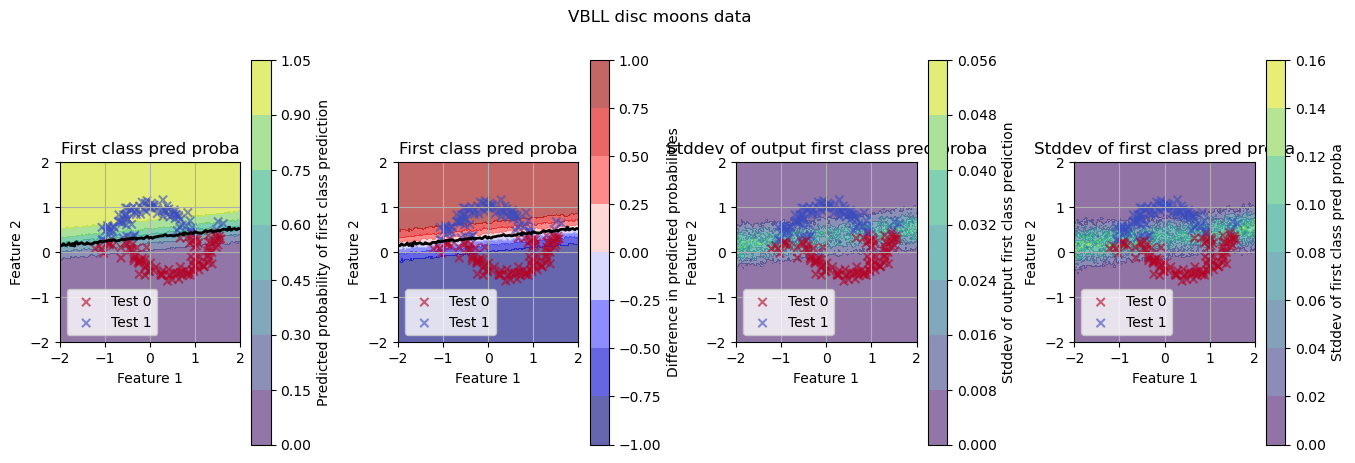

In [169]:
plt.figure(figsize=(16, 5))
plt.tight_layout()
plt.suptitle(f"VBLL {vbll_disc_cfg.TYPE} {data_str} data")

ranges = [-2, 2]
x_range = np.linspace(ranges[0], ranges[1], 100)
y_range = np.linspace(ranges[0], ranges[1], 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)

Z = proceed_prediction_grid_vbll(model_vbll, X_grid, Y_grid)
Z_grid = Z[:, 0].numpy().reshape(X_grid.shape)

plt.subplot(1, 4, 1)
plt.contourf(X_grid, Y_grid, Z_grid, cmap='viridis', alpha=0.6)
plt.colorbar(label='Predicted probability of first class prediction')

plt.axis('scaled')
plt.grid(True)
plt.contour(X_grid, Y_grid, Z_grid, levels=[0.5], colors='black', linewidths=2)

plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c=predictions_vbll[y_test == 0], cmap='coolwarm', marker="x", alpha=0.6, label='Test 0')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c=predictions_vbll[y_test == 1], cmap='coolwarm', marker="x", alpha=0.6, label='Test 1')

plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('First class pred proba')
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.subplot(1, 4, 2)
plt.contourf(X_grid, Y_grid, Z_grid - Z[:, 1].numpy().reshape(X_grid.shape), cmap='seismic', alpha=0.6)
plt.colorbar(label='Difference in predicted probabilities')

plt.axis('scaled')
plt.grid(True)
plt.contour(X_grid, Y_grid, Z_grid, levels=[0.5], colors='black', linewidths=2)

plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c=predictions_vbll[y_test == 0], cmap='coolwarm', marker="x", alpha=0.6, label='Test 0')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c=predictions_vbll[y_test == 1], cmap='coolwarm', marker="x", alpha=0.6, label='Test 1')

plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('First class pred proba')
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.subplot(1, 4, 3)
std_preds = proceed_predictions_stddev_vbll(model_vbll, X_grid, Y_grid, n_repeats=10)
std_preds_grid = std_preds.numpy().reshape(X_grid.shape)

plt.contourf(X_grid, Y_grid, std_preds_grid, cmap='viridis', alpha=0.6)
plt.colorbar(label='Stddev of output first class prediction')
plt.axis('scaled')
plt.grid(True)

plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c=predictions_vbll[y_test == 0], cmap='coolwarm', marker="x", alpha=0.6, label='Test 0')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c=predictions_vbll[y_test == 1], cmap='coolwarm', marker="x", alpha=0.6, label='Test 1')

plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Stddev of output first class pred proba')
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.subplot(1, 4, 4)
std_preds = proceed_logits_stddev_vbll(model_vbll, vbll_disc_cfg.TYPE, X_grid, Y_grid, n_samples=10)
std_preds_grid = std_preds.numpy().reshape(X_grid.shape)

plt.contourf(X_grid, Y_grid, std_preds_grid, cmap='viridis', alpha=0.6)
plt.colorbar(label='Stddev of first class pred proba')
plt.axis('scaled')
plt.grid(True)

plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c=predictions_vbll[y_test == 0], cmap='coolwarm', marker="x", alpha=0.6, label='Test 0')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c=predictions_vbll[y_test == 1], cmap='coolwarm', marker="x", alpha=0.6, label='Test 1')

plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Stddev of first class pred proba')
plt.subplots_adjust(hspace=0.5, wspace=0.5)


In [51]:
def plot_all(model, vbll_type, data_str, grid_X, grid_Y, X_test, y_test, n_samples):
    # misclassification; first class proba; difference first-second class probas; stddev of first class proba; var p; var y; p*(1-p)
    probs, predicted, p_1minusp = proceed_testing_vbll(model, X_test)
    print(predicted, y_test)
    misclassified = predicted = torch.from_numpy(np.array(y_test))
    points = torch.from_numpy(np.column_stack((grid_X.flatten(), grid_Y.flatten()))).to(model.input_layer.weight.dtype)
    if vbll_type == "disc":
        with torch.no_grad():
            softmax_samples = F.softmax(model.logit_predictive(points).rsample(sample_shape=torch.Size([n_samples])), dim=-1)
    elif vbll_type == "gen":
        with torch.no_grad():
            out = model.logit_predictive_likedisc(points, n_samples = 10)
            softmax_samples = torch.clip(F.softmax(out, dim=-1), min=0., max=1.)
    p = softmax_samples[:, :, 0]
    # probability for 0 class of i model j datapoint p[i, j]
    phat = torch.mean(p, dim=0)
    # mean probability for 0 for j datapoint phat[j] = y predicted for j datapoint
    varp = torch.var(p, dim=0) # assert all(torch.isclose(varp, torch.mean((p-phat.unsqueeze_(0))**2, dim=0))) #FIXME
    # var probability for 0 for j datapoint varp[j] for j datapoint

    # now variance of output
    ys = torch.empty((n_samples, len(points)))
    for i in range(n_samples):
        with torch.no_grad():
            if vbll_type == "disc":
                preds = model.predictive(points, 10)
            elif vbll_type == "gen":
                preds = torch.mean(model.logit_predictive_likedisc(points, 10), dim=0)
            ys[i] = torch.argmax(preds, dim=1)

    varout = torch.mean(((1-ys)-phat)**2, dim=0)

    grid_Z = proceed_prediction_grid_vbll(model, grid_X, grid_Y)
    grid_Z_zeroclass = grid_Z[:, 0].numpy().reshape(grid_X.shape)
    grid_Z_firstclass = grid_Z[:, 1].numpy().reshape(grid_X.shape)

    ###
    fig = plt.figure(figsize=(20, 12))
    plt.tight_layout()
    
    ax = fig.add_subplot(2, 3, 1)
    ax.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c=predicted[y_test == 0], cmap='coolwarm', marker="x", alpha=0.6, label='Test 0')
    ax.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c=predicted[y_test == 1], cmap='coolwarm', marker="x", alpha=0.6, label='Test 1')
    ax.scatter(X_test[misclassified][:, 0], X_test[misclassified][:, 1], edgecolors="black", facecolors='none', marker="s", alpha=1.0, label="misclassified")
    # plt.colorbar(ax=ax)
    ax.grid(True)
    # fig.colorbar(im, cax=make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05), orientation='vertical')
    ax.set_title(f'Misclassifications. Accuracy {(1 - sum(misclassified)/len(misclassified)):3f}')

    ax = fig.add_subplot(2, 3, 2)
    im = ax.contourf(grid_X, grid_Y, grid_Z_zeroclass, cmap='seismic', alpha=0.6)
    ax.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c=predictions_vbll[y_test == 0], cmap='coolwarm', marker="x", alpha=0.6, label='Test 0')
    ax.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c=predictions_vbll[y_test == 1], cmap='coolwarm', marker="x", alpha=0.6, label='Test 1')
    ax.grid(True)
    fig.colorbar(im, cax=make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05), orientation='vertical')
    ax.set_title('First class prediction')

    ax = fig.add_subplot(2, 3, 3)
    im = ax.contourf(grid_X, grid_Y, grid_Z_zeroclass - grid_Z_firstclass, cmap='seismic', alpha=0.6)
    ax.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c=predictions_vbll[y_test == 0], cmap='coolwarm', marker="x", alpha=0.6, label='Test 0')
    ax.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c=predictions_vbll[y_test == 1], cmap='coolwarm', marker="x", alpha=0.6, label='Test 1')
    ax.grid(True)
    fig.colorbar(im, cax=make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05), orientation='vertical')
    ax.set_title('Difference class prediction')

    ax = fig.add_subplot(2, 3, 4)
    im = ax.contourf(grid_X, grid_Y, varp.numpy().reshape(grid_X.shape), cmap='coolwarm', alpha=0.6)
    ax.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c=predictions_vbll[y_test == 0], cmap='coolwarm', marker="x", alpha=0.6, label='Test 0')
    ax.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c=predictions_vbll[y_test == 1], cmap='coolwarm', marker="x", alpha=0.6, label='Test 1')
    ax.grid(True)
    fig.colorbar(im, cax=make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05), orientation='vertical')
    ax.set_title(f'Variance of zero class proba {n_samples}')

    ax = fig.add_subplot(2, 3, 5)
    im = ax.contourf(grid_X, grid_Y, varout.numpy().reshape(grid_X.shape), cmap='coolwarm', alpha=0.6)
    ax.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c=predictions_vbll[y_test == 0], cmap='coolwarm', marker="x", alpha=0.6, label='Test 0')
    ax.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c=predictions_vbll[y_test == 1], cmap='coolwarm', marker="x", alpha=0.6, label='Test 1')
    ax.grid(True)
    fig.colorbar(im, cax=make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05), orientation='vertical')
    ax.set_title(f'Variance of output {n_samples} repeats | 10 each prediction')

    ax = fig.add_subplot(2, 3, 6)
    p_1minusp
    im = ax.contourf(grid_X, grid_Y, grid_Z_zeroclass * grid_Z_firstclass, cmap='coolwarm', alpha=0.6)
    ax.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c=predicted[y_test == 0], cmap='coolwarm', marker="x", alpha=0.6, label='Test 0')
    ax.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c=predicted[y_test == 1], cmap='coolwarm', marker="x", alpha=0.6, label='Test 1')
    ax.grid(True)
    fig.colorbar(im, cax=make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05), orientation='vertical')
    ax.set_title(f'first class proba * second class proba')

    avg_p = torch.mean(p, dim=1)
    avg_p_overall = torch.mean(avg_p)
    between_model_variance = torch.mean((avg_p-avg_p_overall)**2).item()
    within_model_variance = torch.mean(torch.mean((p-phat)**2, dim=1))

    plt.suptitle(f"VBLL {vbll_type} {data_str} data. Between {between_model_variance:.3e} + Within {within_model_variance:3e} = TotalVar {(between_model_variance+within_model_variance):.5f}")
    
    return fig

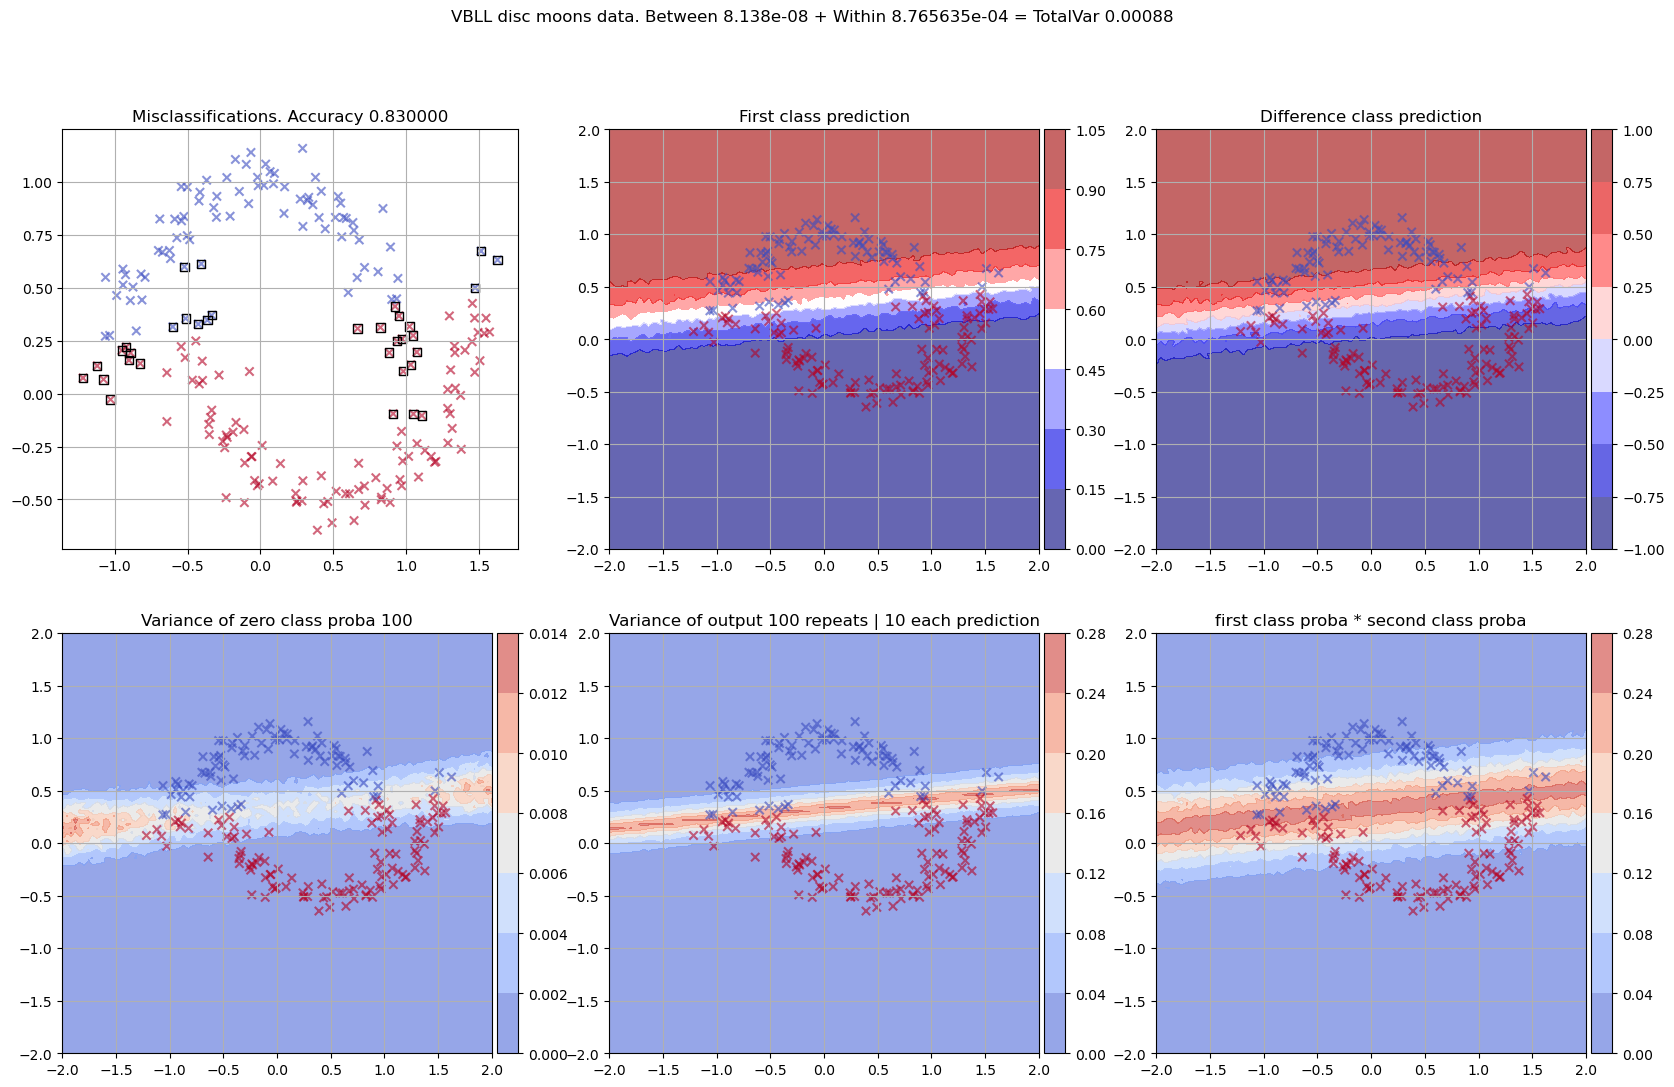

In [172]:
n_samples = 100
ranges = [-2, 2]
range_x = np.linspace(ranges[0], ranges[1], 100)
range_y = np.linspace(ranges[0], ranges[1], 100)
grid_X, grid_Y = np.meshgrid(range_x, range_y)
g = plot_all(model_vbll, "disc", data_str, grid_X, grid_Y, X_test, y_test, n_samples)
g.show()

### VBLL Gen

In [32]:
class vbll_gen_cfg:
    TYPE = "gen"
    REG_WEIGHT = 1./len(X_train)
    PARAM = 'diagonal'
    SOFTMAX_BOUND = "jensen"
    RETURN_EMPIRICAL = True
    SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
    RETURN_OOD = True
    PRIOR_SCALE = 0.01

In [33]:
model_vbll_gen, optimizer_vbll_gen = init_training_vbll(vbll_gen_cfg, lr=0.001)
losses_vbll_gen, accuracies_vbll_gen = proceed_training_vbll(model_vbll_gen, train_loader, optimizer_vbll_gen, num_epochs=50)
probs_vbll_gen, predictions_vbll_gen, simple_uncertainties_vbll_gen = proceed_testing_vbll(model_vbll_gen, X_test)

Epoch [1/50], Train Loss: 1335.7427, Test Accuracy: 63.00%
Epoch [2/50], Train Loss: 1167.9491, Test Accuracy: 72.50%
Epoch [3/50], Train Loss: 1040.9036, Test Accuracy: 80.00%
Epoch [4/50], Train Loss: 936.1044, Test Accuracy: 85.00%
Epoch [5/50], Train Loss: 840.5546, Test Accuracy: 84.00%
Epoch [6/50], Train Loss: 764.7011, Test Accuracy: 87.00%
Epoch [7/50], Train Loss: 700.7176, Test Accuracy: 86.00%
Epoch [8/50], Train Loss: 636.7357, Test Accuracy: 85.50%
Epoch [9/50], Train Loss: 586.8634, Test Accuracy: 86.00%
Epoch [10/50], Train Loss: 541.6170, Test Accuracy: 86.50%
Epoch [11/50], Train Loss: 501.3182, Test Accuracy: 86.00%
Epoch [12/50], Train Loss: 466.7413, Test Accuracy: 85.00%
Epoch [13/50], Train Loss: 434.6160, Test Accuracy: 86.00%
Epoch [14/50], Train Loss: 404.7127, Test Accuracy: 85.00%
Epoch [15/50], Train Loss: 376.8886, Test Accuracy: 86.00%
Epoch [16/50], Train Loss: 354.4411, Test Accuracy: 85.50%
Epoch [17/50], Train Loss: 335.8017, Test Accuracy: 85.50%
Epo

Text(0.5, 1.0, 'test acc')

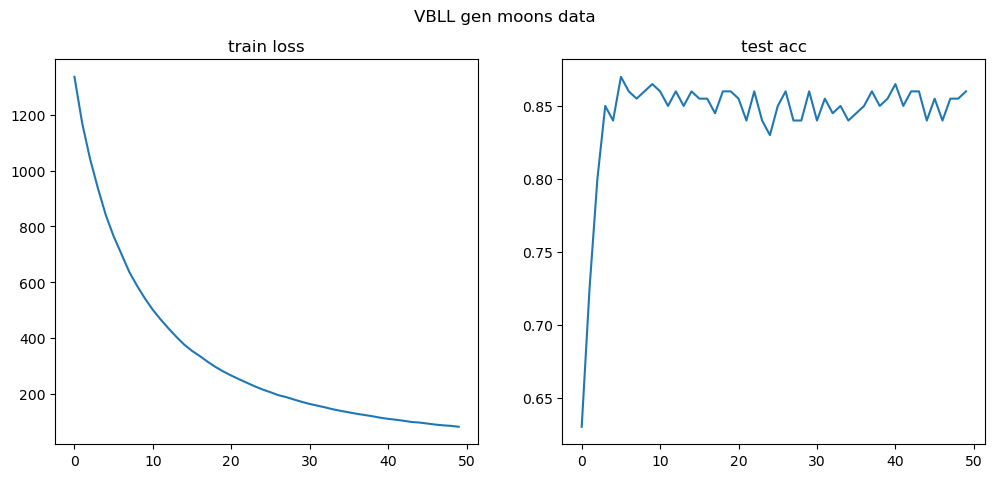

In [34]:
plt.figure(figsize=(12, 5))
plt.suptitle(f"VBLL {vbll_gen_cfg.TYPE} {data_str} data")
plt.subplot(1, 2, 1)
plt.plot(losses_vbll_gen)
plt.title("train loss")
plt.subplot(1, 2, 2)
plt.plot(accuracies_vbll_gen)
plt.title("test acc")

NameError: name 'predictions_vbll' is not defined

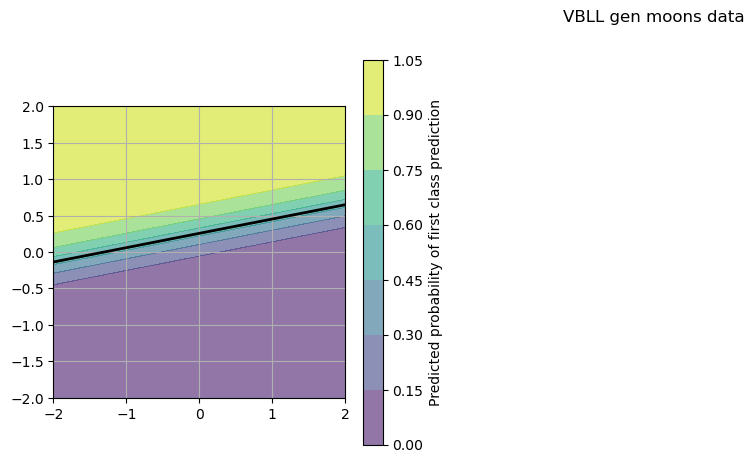

In [39]:
plt.figure(figsize=(16, 5))
plt.tight_layout()
plt.suptitle(f"VBLL {vbll_gen_cfg.TYPE} {data_str} data")

ranges = [-2, 2]
x_range = np.linspace(ranges[0], ranges[1], 100)
y_range = np.linspace(ranges[0], ranges[1], 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)

Z = proceed_prediction_grid_vbll(model_vbll_gen, X_grid, Y_grid)
Z_grid = Z[:, 0].numpy().reshape(X_grid.shape)

plt.subplot(1, 3, 1)
plt.contourf(X_grid, Y_grid, Z_grid, cmap='viridis', alpha=0.6)
plt.colorbar(label='Predicted probability of first class prediction')

plt.axis('scaled')
plt.grid(True)
plt.contour(X_grid, Y_grid, Z_grid, levels=[0.5], colors='black', linewidths=2)

plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c=predictions_vbll[y_test == 0], cmap='coolwarm', marker="x", alpha=0.6, label='Test 0')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c=predictions_vbll[y_test == 1], cmap='coolwarm', marker="x", alpha=0.6, label='Test 1')

plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('First class pred proba')
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.subplot(1, 3, 2)
std_preds = proceed_predictions_stddev_vbll(model_vbll_gen, X_grid, Y_grid, n_repeats=10)
std_preds_grid = std_preds.numpy().reshape(X_grid.shape)

plt.contourf(X_grid, Y_grid, std_preds_grid, cmap='viridis', alpha=0.6)
plt.colorbar(label='Stddev of output first class prediction')
plt.axis('scaled')
plt.grid(True)

plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c=predictions_vbll[y_test == 0], cmap='coolwarm', marker="x", alpha=0.6, label='Test 0')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c=predictions_vbll[y_test == 1], cmap='coolwarm', marker="x", alpha=0.6, label='Test 1')

plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Stddev of output first class pred proba')
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.subplot(1, 3, 3)
std_preds = proceed_logits_stddev_vbll(model_vbll_gen, vbll_gen_cfg.TYPE, X_grid, Y_grid, n_samples=10)
std_preds_grid = std_preds.numpy().reshape(X_grid.shape)

plt.contourf(X_grid, Y_grid, std_preds_grid, cmap='viridis', alpha=0.6)
plt.colorbar(label='Stddev of first class pred proba')
plt.axis('scaled')
plt.grid(True)

plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], c=predictions_vbll[y_test == 0], cmap='coolwarm', marker="x", alpha=0.6, label='Test 0')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c=predictions_vbll[y_test == 1], cmap='coolwarm', marker="x", alpha=0.6, label='Test 1')

plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Stddev of first class pred proba')
plt.subplots_adjust(hspace=0.5, wspace=0.5)


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 1]) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

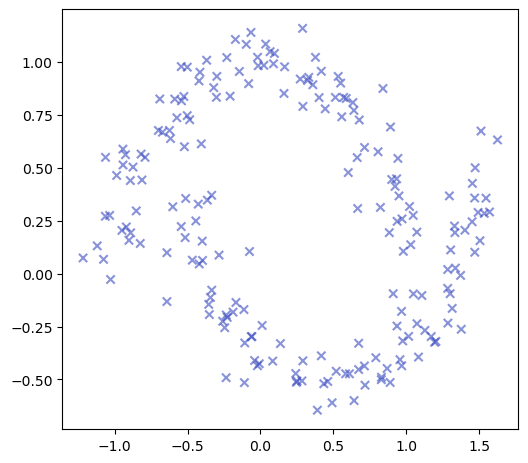

In [52]:
n_samples = 100
ranges = [-2, 2]
range_x = np.linspace(ranges[0], ranges[1], 100)
range_y = np.linspace(ranges[0], ranges[1], 100)
grid_X, grid_Y = np.meshgrid(range_x, range_y)
g = plot_all(model_vbll_gen, "gen", data_str, grid_X, grid_Y, X_test, y_test, n_samples)
g.show()

In [ ]:
model_vbll_gen.eval()
X_test_tensor = torch.FloatTensor(X_test)
logprobabs = model_vbll_gen.logit_predictive(X_test_tensor)

In [ ]:
# Negative-log-likelihood
nll = F.binary_cross_entropy_with_logits(model_vbll_gen(X_test_tensor).squeeze(), torch.IntTensor(y_test), reduction='sum')
# Negative-log-prior
nlp = 1/2 * W.flatten() @ (1/var0 * torch.eye(W.numel())) @ W.flatten()

In [ ]:
with torch.no_grad():
    out = model_vbll_gen(X_test_tensor)
    probs = out.predictive.probs
    predicted = torch.argmax(probs, 1) 